In [1]:
import pickle

In [2]:
with open("data/datafile_all.pkl", "rb") as f:
    all_data = pickle.load(f)

In [3]:
import random

In [4]:
all_data[10]

{'id': '0704.0011',
 'submitter': 'Clifton Cunningham',
 'authors': 'Clifton Cunningham and Lassina Dembele',
 'title': 'Computing genus 2 Hilbert-Siegel modular forms over $\\Q(\\sqrt{5})$ via\n  the Jacquet-Langlands correspondence',
 'comments': '14 pages; title changed; to appear in Experimental Mathematics',
 'journal-ref': None,
 'doi': None,
 'report-no': None,
 'categories': 'math.NT math.AG',
 'license': 'http://arxiv.org/licenses/nonexclusive-distrib/1.0/',
 'abstract': '  In this paper we present an algorithm for computing Hecke eigensystems of\nHilbert-Siegel cusp forms over real quadratic fields of narrow class number\none. We give some illustrative examples using the quadratic field\n$\\Q(\\sqrt{5})$. In those examples, we identify Hilbert-Siegel eigenforms that\nare possible lifts from Hilbert eigenforms.\n',
 'versions': [{'version': 'v1', 'created': 'Sat, 31 Mar 2007 05:32:49 GMT'},
  {'version': 'v2', 'created': 'Tue, 19 Aug 2008 04:46:47 GMT'},
  {'version': 'v3', 'c

# topic Modeling
try to fetch topic from text abstract

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-mpnet-base-v2')

In [7]:
data = random.sample(all_data, 10000)

In [8]:
data_test = random.sample(all_data, 30)

In [9]:
all_text = [x['abstract'] for x in data]

In [10]:
import pandas as pd
import numpy as np
import re

df = pd.DataFrame(all_text, columns=["input_text"])
df['pre_processed_text'] = df['input_text'].apply(lambda x : re.sub(r"\(.*\)", "",x))
df['pre_processed_text'] = df['pre_processed_text'].apply(lambda x : re.sub(r"\W+", " ",x))
df['pre_processed_text'] = df['pre_processed_text'].str.lower()
df['pre_processed_text'] = df['pre_processed_text'].str.strip()

In [11]:
all_category = [x['categories'] for x in data]

In [12]:
df["categories"] = all_category

In [13]:
df.to_pickle("train.pkl")

In [14]:
all_text = df['pre_processed_text'].to_list()

In [15]:
len(all_text)

10000

In [16]:
%%time
embeddings = model.encode(all_text, show_progress_bar=True)

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

CPU times: total: 3h 24min 49s
Wall time: 51min 16s


In [17]:
embeddings.shape

(10000, 768)

In [18]:
df["embedding"] = embeddings.tolist()

In [22]:
from yellowbrick.cluster import KElbowVisualizer

In [20]:
n_n = 20

In [25]:
import umap
umap_embeddings = umap.UMAP(n_neighbors=n_n, 
                            n_components=100, 
                            metric='cosine').fit_transform(embeddings)

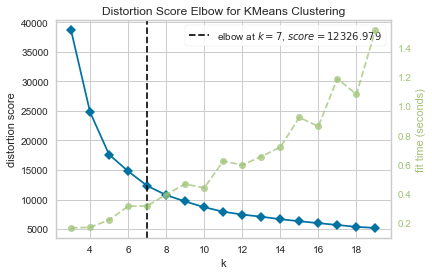

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [27]:
from sklearn.cluster import KMeans

model = KMeans()
visualizer = KElbowVisualizer(model, k=range(3,20,1))

visualizer.fit(umap_embeddings)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [28]:
best_k = visualizer.elbow_value_

<Figure size 432x288 with 0 Axes>

In [29]:
best_k

7

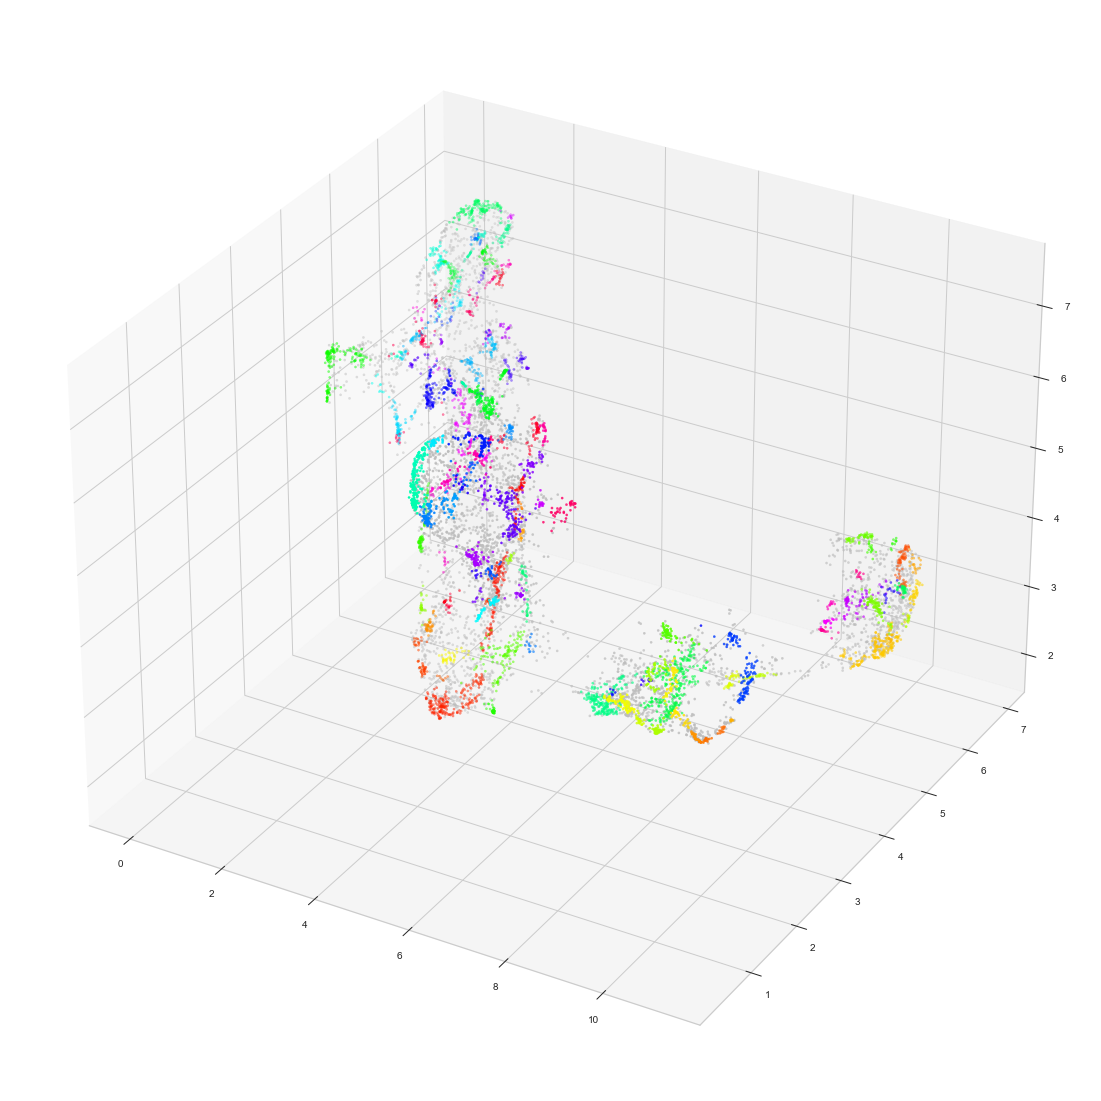

In [31]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=int(best_k),
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)


umap_data = umap.UMAP(n_neighbors=n_n, n_components=3, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y', 'z'])
result['labels'] = cluster.labels_

# Visualize clusters
fig = plt.figure(figsize=(40, 20))
ax = plt.axes(projection='3d')
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
ax.scatter3D(outliers.x, outliers.y, outliers.z,color='#BDBDBD', s=5)
ax.scatter3D(clustered.x, clustered.y, clustered.z, c=clustered.labels, s=5, cmap='hsv_r')

In [32]:
docs_df = pd.DataFrame(all_text, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [33]:
docs_df["categories"] = df[df["pre_processed_text"] == docs_df["Doc"]]["categories"]
docs_df["embedding"] = df[df["pre_processed_text"] == docs_df["Doc"]]["embedding"]

In [34]:
docs_df.head()

,Doc,Topic,Doc_ID,categories,embedding
0,one common task in image forensics is to detec...,67,0,cs.CV cs.MM,"[-0.014025911688804626, 0.039916254580020905, ..."
1,in the present paper the hawking radiation of ...,104,1,gr-qc,"[0.024981863796710968, -0.050757996737957, -0...."
2,in a previous work the second author gives a f...,-1,2,math.DG,"[-0.03342597559094429, 0.015192278660833836, -..."
3,the self consistent quasiparticle random phase...,121,3,nucl-th,"[0.023393791168928146, -0.00954490713775158, 0..."
4,we present variants of the conjugate gradient ...,2,4,math.NA,"[-0.009489459916949272, 0.010598402470350266, ..."


In [35]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(all_text))

In [36]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

C:\Users\amiyamandal\Miniconda3\envs\py38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
0,-1,4656
105,104,249
98,97,172
147,146,160
102,101,133
166,165,132
109,108,117
45,44,116
93,92,108
55,54,89


In [37]:
top_n_words

{-1: [('data', 0.004820523528370216),
  ('quantum', 0.004800168998878306),
  ('results', 0.004701287355670755),
  ('using', 0.00469042154940016),
  ('time', 0.00467004485473743),
  ('energy', 0.004570224655115998),
  ('model', 0.004497988941347951),
  ('paper', 0.004455941896009465),
  ('models', 0.004399794438914266),
  ('based', 0.004351034867738689),
  ('new', 0.004296745963747514),
  ('systems', 0.004293856832033868),
  ('study', 0.004286919204704116),
  ('field', 0.004176519188828737),
  ('state', 0.004166231401975491),
  ('non', 0.004082351076968264),
  ('space', 0.0040602986562078966),
  ('present', 0.004052390963146597),
  ('method', 0.0040264433357250955),
  ('used', 0.004018940263949922)],
 0: [('withdrawn', 0.26338157051176786),
  ('hep', 0.22437758393183496),
  ('th', 0.17141942262611723),
  ('qc', 0.14709131593898678),
  ('gr', 0.12447566043537883),
  ('comment', 0.12148645983598728),
  ('bessel', 0.1166499948348093),
  ('author', 0.11340827844212034),
  ('math', 0.1014289

In [38]:
import faiss

In [47]:
ncentroids = int(best_k)
niter = 100
verbose = True
d = embeddings.shape[1]

In [48]:
d

768

In [49]:
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(embeddings)

1375.1424560546875

In [50]:
D, I = kmeans.index.search(embeddings, 1)

In [51]:
D

array([[0.7981229 ],
       [0.62023944],
       [0.89890563],
       ...,
       [0.636054  ],
       [0.832916  ],
       [0.5852453 ]], dtype=float32)

In [52]:
I

array([[3],
       [5],
       [5],
       ...,
       [5],
       [1],
       [5]], dtype=int64)

In [53]:
umap_data = umap.UMAP(n_neighbors=n_n, n_components=3, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y', 'z'])
result['labels'] = I

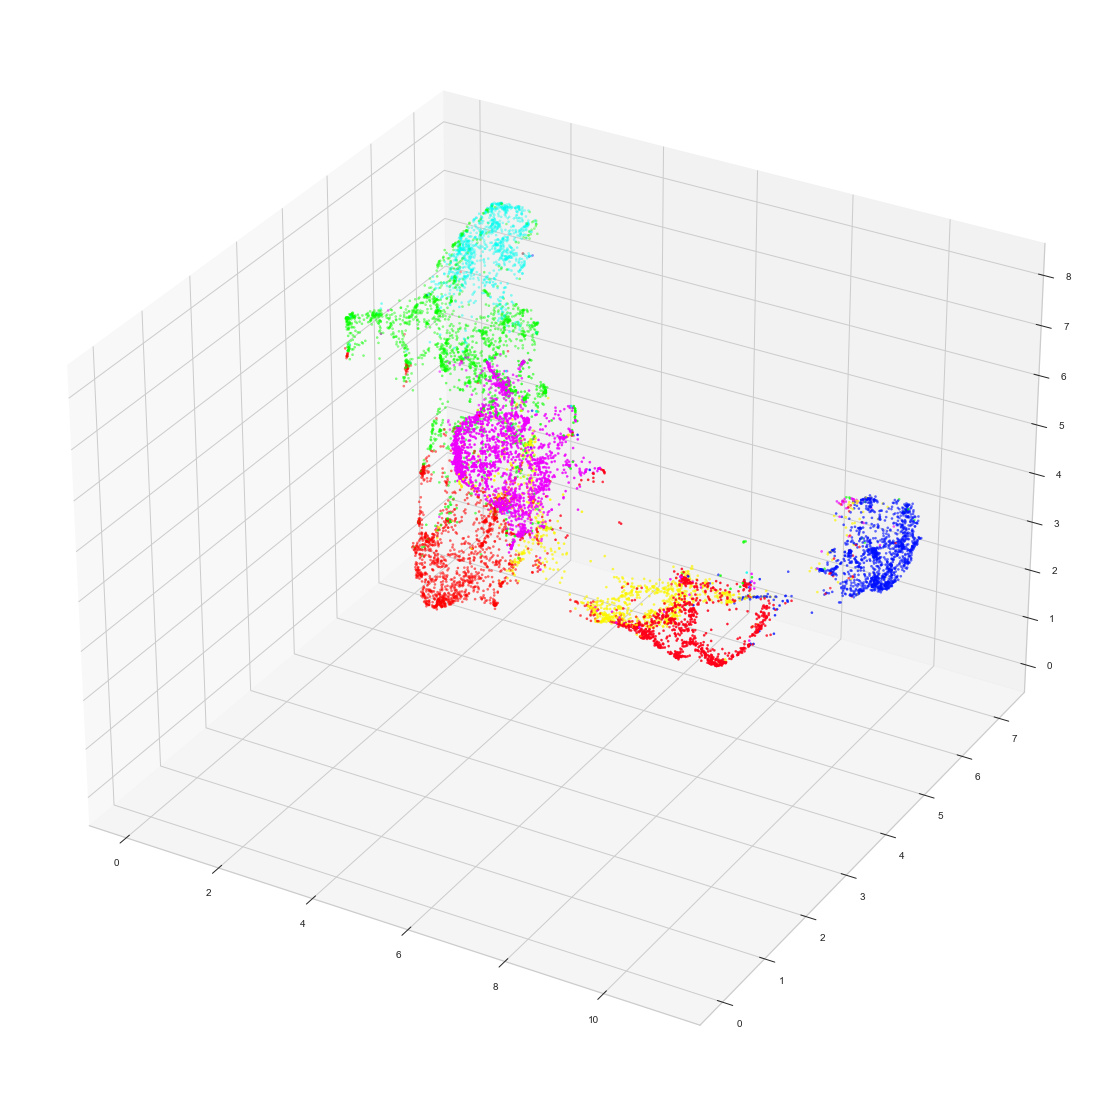

In [54]:
# Visualize clusters
fig = plt.figure(figsize=(40, 20))
ax = plt.axes(projection='3d')
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
ax.scatter3D(outliers.x, outliers.y, outliers.z,color='#BDBDBD', s=5)
ax.scatter3D(clustered.x, clustered.y, clustered.z, c=clustered.labels, s=5, cmap='hsv_r')

In [33]:
def pre_process(x:str):
    x = re.sub(r"\(.*\)", "",x)
    x = re.sub(r"\W+", " ",x)
    x = x.lower()
    x = x.strip()
    return x

In [43]:
test_text = pre_process(data[50]["abstract"])

In [44]:
test_text

'we consider the problem of characterizing an inner bound to the capacity region of a 3 user classical quantum interference channel the best known coding scheme for communicating over cqics is based on unstructured random codes and employs the techniques of message splitting and superposition coding for classical 3 user interference channels it has been proven that coding techniques based on coset codes codes possessing algebraic closure properties strictly outperform all coding techniques based on unstructured codes in this work we develop analogous techniques based on coset codes for 3 to 1 cqics a subclass of 3 user cqics we analyze its performance and derive a new inner bound to the capacity region of 3 to 1 cqics that subsume the current known largest and strictly enlarges the same for identified examples'

In [45]:
em = model.encode([test_text])

# classification model

In [71]:
import torch
from torch.nn import functional as F
from torch import nn
from pytorch_lightning import LightningModule

In [73]:
docs_df.head()

,Doc,Topic,Doc_ID,topic,categories,embedding
0,we present a set of lectures on topics of adva...,-1,0,7,math.HO,"[-0.08163873851299286, -0.03701891005039215, -..."
1,reliably detecting anomalies in a given set of...,18,1,4,cs.LG cs.CV stat.ML,"[-0.009611744433641434, 0.060234081000089645, ..."
2,we consider the error analysis of lagrange int...,3,2,3,math.NA,"[0.011039530858397484, -0.005772748962044716, ..."
3,the purpose of this paper is to present an int...,3,3,18,math.QA math.CO,"[0.0012696852209046483, -0.037827953696250916,..."
4,we present an online stochastic model predicti...,-1,4,3,eess.SY cs.SY,"[-0.006156288553029299, 0.04764825850725174, -..."


array([<AxesSubplot:title={'center':'topic'}>], dtype=object)

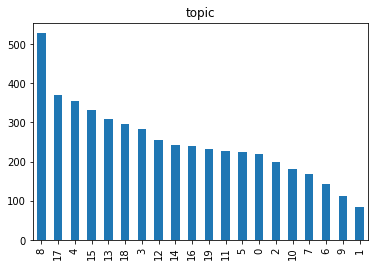

In [80]:
# cluster using faiss
docs_df['topic'].value_counts().plot(kind='bar', subplots=True)

array([<AxesSubplot:title={'center':'Topic'}>], dtype=object)

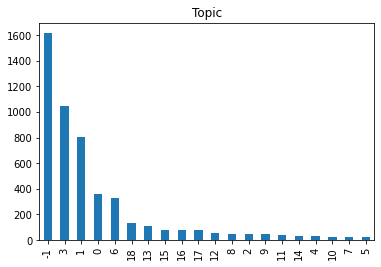

In [81]:
# cluster using UMAP->HDBSCAN
docs_df['Topic'].value_counts().plot(kind='bar', subplots=True)

In [ ]:
class ModelClassification(LightningModule):
    def __init__(self):
        super().__init__()
        
        self.layer_1 = nn.Linear(768, 256)
        self.layer_2 = nn.Linear(256, 128)
        self.layer_3 = nn.Linear(128, 20)
    def forward(self, x):
        batch_size, dense_vector = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        x = F.relu(x)
        x = self.layer_3(x)

        x = F.log_softmax(x, dim=1)
        return x
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        return loss
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)
    